# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See [this notebook](https://github.com/kundajelab/tfmodisco/blob/de01768331fd63df6cb9d6b9707589928194a1e4/examples/H1ESC_Nanog_gkmsvm/Nanog_GkmExplain_Generate_Data.ipynb) for how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2021-02-26 16:31:41--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: ‘positives_test.fa.gz’

positives_test.fa.g 100%[===================>]  73.28K  --.-KB/s    in 0.02s   

2021-02-26 16:31:41 (3.10 MB/s) - ‘positives_test.fa.gz’ saved [75038/75038]

--2021-02-26 16:31:42--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


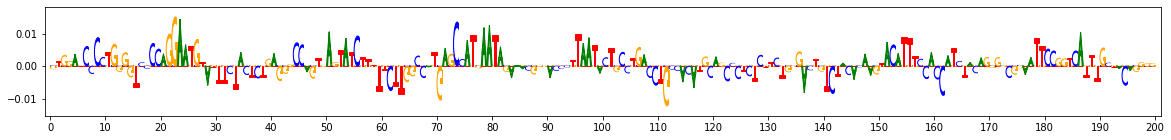

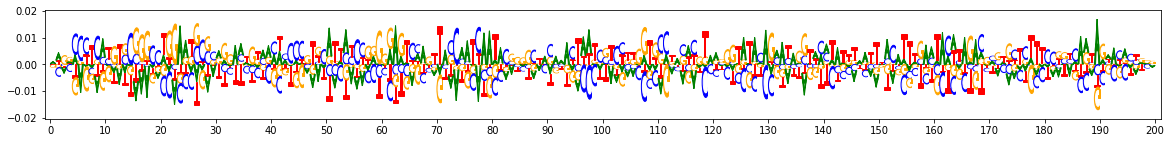

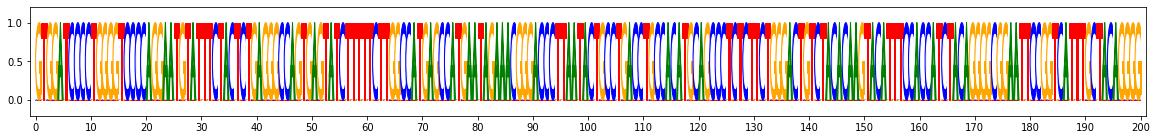

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has the following modifications from the default settings:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- (new in version 0.5.6.0) MEME is run on the seqlets to find 10 motifs, and the significant motifs are used to initialize TF-MoDISco's Leiden clustering. This initialization is handled by the initclusterer_factory argument.
- The `final_min_cluster_size` is set to 20 rather than the default of 30. The `final_min_cluster_size` determines the minimum support needed (in terms of number of seqlets) for a cluster to be displayed. It was lowered here to potentially enable better comparison to the MEME results, as the MEME motifs can sometimes have very few seqlets.

TF-MoDISco is using the TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term
MEMORY 0.34541568
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


For increasing = True , the minimum IR precision was 0.28762191141268867 occurring at 1.1961500000490233e-06 implying a frac_neg of 0.40374895862260485
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4829015187051677 occurring at -5.614999999965353e-07 implying a frac_neg of 0.9338676019623297
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.21752344639999993  and  0.15626441020500015 with frac passing 0.07338541666666666
Final raw thresholds are -0.21752344639999993  and  0.15626441020500015
Final transformed thresholds are -0.9723900462962963  and  0.9213773148148148


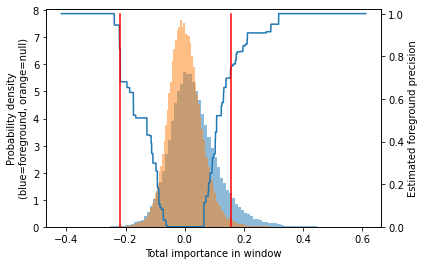

Got 923 coords
After resolving overlaps, got 923 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9212773148148148
MEMORY 0.424804352
923 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [903]
Idx to activities:  {0: '1'}
MEMORY 0.42483712
On metacluster 0
Metacluster size 903
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod zoops -nmotifs 10 -p 4 -minw 6 -maxw 50 -objfun classic -revcomp -markov_order 0 -oc meme_out/metacluster0
Duration of MEME: 449.3061988353729 seconds
Skipping motif AGCAGGSYYCWSAG as e-value 1.5 does not meet threshold of 0.05
Skipping motif RAKSCCTTTGAAR as e-value 200.0 does not meet threshold of 0.05
Skipping motif GAATAGAYKGTRAATGTTTCT as e-value 260000.0 does not meet threshold of 0.05
Skipping motif KGCCAGSMAKG as e-value 670000.0 does not meet threshold of 0.0

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   16.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   16.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    2.0s finished


Constructing csr matrix...
csr matrix made in 0.19878697395324707 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    2.0s finished


Constructing csr matrix...
csr matrix made in 0.2009110450744629 s
Finished embedding computation in 37.29 s
MEMORY 0.762875904
Starting affinity matrix computations
MEMORY 0.762875904
Batching in slices of size 903


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

Finished affinity matrix computations in 2.33 s
MEMORY 0.799973376
(Round 1) Computed coarse affmat
MEMORY 0.799973376
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.799973376


Launching nearest neighbors affmat calculation job
MEMORY 0.803733504
Parallel runs completed
MEMORY 0.838291456
Job completed in: 15.69 s
MEMORY 0.838291456
Launching nearest neighbors affmat calculation job
MEMORY 0.838291456
Parallel runs completed
MEMORY 0.858750976
Job completed in: 15.14 s
MEMORY 0.858750976
(Round 1) Computed affinity matrix on nearest neighbors in 31.1 s
MEMORY 0.868184064
Filtered down to 893 of 903
(Round 1) Retained 893 rows out of 903 after filtering
MEMORY 0.868564992
(Round 1) Computing density adapted affmat
MEMORY 0.870547456
[t-SNE] Computed conditional probabilities for sample 893 / 893
[t-SNE] Mean sigma: 0.235491
(Round 1) Computing clustering
MEMORY 0.87281664
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s


Quality: 0.650615485424479
Quality: 0.6508202170876235
Quality: 0.6514824256206074
Quality: 0.6515780458654592
Quality: 0.6517441330928022
Quality: 0.6517848272673595
Quality: 0.6520603896044888


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s


Got 11 clusters after round 1
Counts:
{2: 160, 4: 62, 5: 32, 0: 250, 1: 229, 9: 6, 7: 26, 3: 88, 8: 7, 6: 31, 10: 2}
MEMORY 0.872955904
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.872955904
Aggregating for cluster 0 with 250 seqlets
MEMORY 0.872955904


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.5s finished


Trimming eliminated 0 seqlets out of 250
Skipped 28 seqlets
Aggregating for cluster 1 with 229 seqlets
MEMORY 0.873218048
Trimming eliminated 0 seqlets out of 229
Skipped 34 seqlets
Aggregating for cluster 2 with 160 seqlets
MEMORY 0.873279488
Trimming eliminated 0 seqlets out of 160
Skipped 23 seqlets
Aggregating for cluster 3 with 88 seqlets
MEMORY 0.873299968
Trimming eliminated 0 seqlets out of 88
Skipped 12 seqlets
Aggregating for cluster 4 with 62 seqlets
MEMORY 0.873299968
Trimming eliminated 0 seqlets out of 62
Skipped 14 seqlets
Aggregating for cluster 5 with 32 seqlets
MEMORY 0.873312256
Trimming eliminated 0 seqlets out of 32
Skipped 2 seqlets
Aggregating for cluster 6 with 31 seqlets
MEMORY 0.873312256
Trimming eliminated 0 seqlets out of 31
Skipped 5 seqlets
Aggregating for cluster 7 with 26 seqlets
MEMORY 0.873312256
Trimming eliminated 0 seqlets out of 26
Skipped 7 seqlets
Aggregating for cluster 8 with 7 seqlets
MEMORY 0.873324544
Trimming eliminated 0 seqlets out of 7


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 765 out of 765 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 765 out of 765 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 765 out of 765 | elapsed:    1.7s finished


Constructing csr matrix...
csr matrix made in 0.16670989990234375 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 765 out of 765 | elapsed:    1.9s finished


Constructing csr matrix...
csr matrix made in 0.16926908493041992 s
Finished embedding computation in 23.54 s
MEMORY 0.876662784
Starting affinity matrix computations
MEMORY 0.876662784
Batching in slices of size 765


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

Finished affinity matrix computations in 2.18 s
MEMORY 0.881713152
(Round 2) Computed coarse affmat
MEMORY 0.881713152
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.881713152


Launching nearest neighbors affmat calculation job
MEMORY 0.883576832
Parallel runs completed
MEMORY 0.903979008
Job completed in: 21.51 s
MEMORY 0.903979008
Launching nearest neighbors affmat calculation job
MEMORY 0.903983104
Parallel runs completed
MEMORY 0.910434304
Job completed in: 21.54 s
MEMORY 0.910434304
(Round 2) Computed affinity matrix on nearest neighbors in 43.29 s
MEMORY 0.914685952
Not applying filtering for rounds above first round
MEMORY 0.914685952
(Round 2) Computing density adapted affmat
MEMORY 0.914690048
[t-SNE] Computed conditional probabilities for sample 765 / 765
[t-SNE] Mean sigma: 0.239903
(Round 2) Computing clustering
MEMORY 0.915439616
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s


Quality: 0.6040543183255664
Quality: 0.6043176753459888
Quality: 0.6045668490796577
Quality: 0.6054226407358384
Quality: 0.6057126771286205
Quality: 0.6060192466088629


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s


Quality: 0.6067987339603884
Got 10 clusters after round 2
Counts:
{0: 218, 5: 57, 1: 188, 3: 97, 6: 14, 4: 65, 9: 5, 8: 6, 2: 107, 7: 8}
MEMORY 0.915439616
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.915439616
Aggregating for cluster 0 with 218 seqlets
MEMORY 0.915439616


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.5s finished


Trimming eliminated 0 seqlets out of 218
Removed 1 duplicate seqlets
Aggregating for cluster 1 with 188 seqlets
MEMORY 0.915546112
Trimming eliminated 0 seqlets out of 188
Removed 1 duplicate seqlets
Aggregating for cluster 2 with 107 seqlets
MEMORY 0.915615744
Trimming eliminated 0 seqlets out of 107
Skipped 1 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 3 with 97 seqlets
MEMORY 0.915664896
Trimming eliminated 0 seqlets out of 97
Skipped 1 seqlets
Aggregating for cluster 4 with 65 seqlets
MEMORY 0.915673088
Trimming eliminated 0 seqlets out of 65
Skipped 4 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 5 with 57 seqlets
MEMORY 0.915697664
Trimming eliminated 0 seqlets out of 57
Skipped 1 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 6 with 14 seqlets
MEMORY 0.915697664
Trimming eliminated 0 seqlets out of 14
Skipped 1 seqlets
Aggregating for cluster 7 with 8 seqlets
MEMORY 0.915697664
Trimming eliminated 0 seqlets out of 8
Aggregating for clus

Applying left/right pad of 2 and 0 for (337, -2, 48) with total sequence length 200
Applying left/right pad of 2 and 0 for (337, -2, 48) with total sequence length 200
Applying left/right pad of 0 and 2 for (479, 152, 202) with total sequence length 200
Applying left/right pad of 0 and 2 for (479, 152, 202) with total sequence length 200
Applying left/right pad of 0 and 8 for (917, 158, 208) with total sequence length 200
Applying left/right pad of 0 and 8 for (917, 158, 208) with total sequence length 200
Applying left/right pad of 6 and 0 for (337, -6, 44) with total sequence length 200
Applying left/right pad of 6 and 0 for (337, -6, 44) with total sequence length 200
Applying left/right pad of 0 and 6 for (479, 156, 206) with total sequence length 200
Applying left/right pad of 0 and 6 for (479, 156, 206) with total sequence length 200
Applying left/right pad of 0 and 8 for (917, 158, 208) with total sequence length 200
Applying left/right pad of 0 and 8 for (917, 158, 208) with to

Performing seqlet reassignment
MEMORY 0.918564864
Cross contin jaccard time taken: 0.04 s
Cross contin jaccard time taken: 0.04 s
Discarded 54 seqlets
Skipped 15 seqlets
Skipped 1 seqlets
Skipped 3 seqlets
Removed 1 duplicate seqlets
Skipped 6 seqlets
Removed 1 duplicate seqlets
Skipped 1 seqlets
Skipped 1 seqlets
Skipped 2 seqlets
Skipped 1 seqlets
Got 7 patterns after reassignment
MEMORY 0.921513984
Total time taken is 213.06s
MEMORY 0.921513984
Applying subclustering to the final motifs
On pattern 0


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.2s finished


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 236 samples in 0.002s...
[t-SNE] Computed neighbors for 236 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 236 / 236
[t-SNE] Mean sigma: 0.291012
[t-SNE] Computed conditional probabilities in 0.008s
[t-SNE] Iteration 50: error = 74.7818146, gradient norm = 0.4798310 (50 iterations in 0.033s)
[t-SNE] Iteration 100: error = 75.5507812, gradient norm = 0.4481443 (50 iterations in 0.037s)
[t-SNE] Iteration 150: error = 80.9614868, gradient norm = 0.4136175 (50 iterations in 0.031s)
[t-SNE] Iteration 200: error = 76.5034790, gradient norm = 0.4771605 (50 iterations in 0.031s)
[t-SNE] Iteration 250: error = 71.2021942, gradient norm = 0.5077677 (50 iterations in 0.031s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.202194


/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Iteration 300: error = 1.5812641, gradient norm = 0.0063641 (50 iterations in 0.031s)
[t-SNE] Iteration 350: error = 1.3097939, gradient norm = 0.0063065 (50 iterations in 0.054s)
[t-SNE] Iteration 400: error = 1.2693558, gradient norm = 0.0019120 (50 iterations in 0.049s)
[t-SNE] Iteration 450: error = 1.2574821, gradient norm = 0.0015599 (50 iterations in 0.041s)
[t-SNE] Iteration 500: error = 1.2434243, gradient norm = 0.0010334 (50 iterations in 0.040s)
[t-SNE] Iteration 550: error = 1.2375398, gradient norm = 0.0005303 (50 iterations in 0.044s)
[t-SNE] Iteration 600: error = 1.2317064, gradient norm = 0.0008925 (50 iterations in 0.049s)
[t-SNE] Iteration 650: error = 1.2311256, gradient norm = 0.0004756 (50 iterations in 0.049s)
[t-SNE] Iteration 700: error = 1.2290919, gradient norm = 0.0005561 (50 iterations in 0.031s)
[t-SNE] Iteration 750: error = 1.2269742, gradient norm = 0.0003080 (50 iterations in 0.050s)
[t-SNE] Iteration 800: error = 1.2271984, gradient norm = 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s


Quality: 0.24842945810563838
Quality: 0.24844734460744838
Quality: 0.2484986574237879


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


On pattern 1
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 187 samples in 0.001s...
[t-SNE] Computed neighbors for 187 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 187 / 187
[t-SNE] Mean sigma: 0.324549
[t-SNE] Computed conditional probabilities in 0.006s
[t-SNE] Iteration 50: error = 69.9377289, gradient norm = 0.4873655 (50 iterations in 0.025s)
[t-SNE] Iteration 100: error = 71.5029831, gradient norm = 0.4683037 (50 iterations in 0.036s)
[t-SNE] Iteration 150: error = 68.5867157, gradient norm = 0.4914977 (50 iterations in 0.039s)
[t-SNE] Iteration 200: error = 66.8888626, gradient norm = 0.5438156 (50 iterations in 0.026s)
[t-SNE] Iteration 250: error = 69.5928192, gradient norm = 0.4528741 (50 iterations in 0.028s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.592819
[t-SNE] Iteration 300: error = 1.4759092, gradient norm = 0.0062624 (50 iterations in 0.025s)
[t-SNE] Iteration 350: error = 1.2635937, gradient norm 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s


Quality: 0.2670890481065075
Quality: 0.2675270224705337
Quality: 0.26861360601013107


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


On pattern 2
[t-SNE] Computing 57 nearest neighbors...
[t-SNE] Indexed 58 samples in 0.001s...
[t-SNE] Computed neighbors for 58 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 58 / 58
[t-SNE] Mean sigma: 0.451593
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 56.5864410, gradient norm = 0.5655447 (50 iterations in 0.014s)
[t-SNE] Iteration 100: error = 58.7206345, gradient norm = 0.4372317 (50 iterations in 0.017s)
[t-SNE] Iteration 150: error = 65.8881226, gradient norm = 0.4119415 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 56.8743362, gradient norm = 0.5707928 (50 iterations in 0.016s)
[t-SNE] Iteration 250: error = 59.5461960, gradient norm = 0.5590407 (50 iterations in 0.014s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.546196
[t-SNE] Iteration 300: error = 1.0810517, gradient norm = 0.0014329 (50 iterations in 0.015s)
[t-SNE] Iteration 350: error = 0.8975900, gradient norm = 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s


Quality: 0.13388594978431587


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  52 out of  52 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


On pattern 3
[t-SNE] Computing 51 nearest neighbors...
[t-SNE] Indexed 52 samples in 0.001s...
[t-SNE] Computed neighbors for 52 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 52 / 52
[t-SNE] Mean sigma: 0.502874
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 59.3088722, gradient norm = 0.4876733 (50 iterations in 0.014s)
[t-SNE] Iteration 100: error = 60.9129372, gradient norm = 0.3832944 (50 iterations in 0.011s)
[t-SNE] Iteration 150: error = 61.9580421, gradient norm = 0.4176208 (50 iterations in 0.014s)
[t-SNE] Iteration 200: error = 64.4575958, gradient norm = 0.4422551 (50 iterations in 0.016s)
[t-SNE] Iteration 250: error = 66.0336609, gradient norm = 0.4474481 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.033661
[t-SNE] Iteration 300: error = 0.9117716, gradient norm = 0.0018565 (50 iterations in 0.013s)
[t-SNE] Iteration 350: error = 0.7579402, gradient norm = 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s


Quality: 0.09036421797360766
Quality: 0.09053540511190016


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  52 out of  52 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


On pattern 4
[t-SNE] Computing 51 nearest neighbors...
[t-SNE] Indexed 52 samples in 0.001s...
[t-SNE] Computed neighbors for 52 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 52 / 52
[t-SNE] Mean sigma: 0.519043
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 56.6397095, gradient norm = 0.4555467 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 55.2146149, gradient norm = 0.4986050 (50 iterations in 0.013s)
[t-SNE] Iteration 150: error = 55.7551613, gradient norm = 0.4653288 (50 iterations in 0.011s)
[t-SNE] Iteration 200: error = 57.9152412, gradient norm = 0.5800253 (50 iterations in 0.010s)
[t-SNE] Iteration 250: error = 54.6509552, gradient norm = 0.5006096 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.650955
[t-SNE] Iteration 300: error = 0.9527899, gradient norm = 0.0018201 (50 iterations in 0.015s)
[t-SNE] Iteration 350: error = 0.7365565, gradient norm = 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s


Quality: 0.13441790157023875


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


On pattern 5
[t-SNE] Computing 40 nearest neighbors...
[t-SNE] Indexed 41 samples in 0.000s...
[t-SNE] Computed neighbors for 41 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 41 / 41
[t-SNE] Mean sigma: 0.585301
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 53.8002510, gradient norm = 0.4732378 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 53.8092194, gradient norm = 0.4973908 (50 iterations in 0.011s)
[t-SNE] Iteration 150: error = 57.9723854, gradient norm = 0.4738771 (50 iterations in 0.010s)
[t-SNE] Iteration 200: error = 48.3987961, gradient norm = 0.5263657 (50 iterations in 0.010s)
[t-SNE] Iteration 250: error = 48.8527985, gradient norm = 0.5336226 (50 iterations in 0.010s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.852798
[t-SNE] Iteration 300: error = 0.7587801, gradient norm = 0.0010519 (50 iterations in 0.010s)
[t-SNE] Iteration 350: error = 0.6133867, gradient norm = 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s


Quality: 0.09869321952737233


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


On pattern 6
[t-SNE] Computing 40 nearest neighbors...
[t-SNE] Indexed 41 samples in 0.001s...
[t-SNE] Computed neighbors for 41 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 41 / 41
[t-SNE] Mean sigma: 0.600182
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 49.8185577, gradient norm = 0.5205067 (50 iterations in 0.014s)
[t-SNE] Iteration 100: error = 51.9854240, gradient norm = 0.4589572 (50 iterations in 0.010s)
[t-SNE] Iteration 150: error = 47.8541870, gradient norm = 0.4920902 (50 iterations in 0.011s)
[t-SNE] Iteration 200: error = 46.6135406, gradient norm = 0.5931830 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 48.1579361, gradient norm = 0.5376996 (50 iterations in 0.010s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.157936
[t-SNE] Iteration 300: error = 0.8641617, gradient norm = 0.0013249 (50 iterations in 0.010s)
[t-SNE] Iteration 350: error = 0.7111045, gradient norm = 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s


Quality: 0.10828394610428606
Quality: 0.10842225482172464


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.4s finished


In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",   
                        #max_num_seqlets_to_use specifies the maximum number of seqlets to use
                        # with MEME (this is to speed up MEME in the cases where the number of seqlets is
                        #  very large)
                        max_num_seqlets_to_use=10000,
                        nmotifs=10,
                        n_jobs=4),
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    final_min_cluster_size=20
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [6]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

<ipython-input-6-19fee09e6a7b>:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  grp = h5py.File("results.hdf5")


Metaclusters heatmap


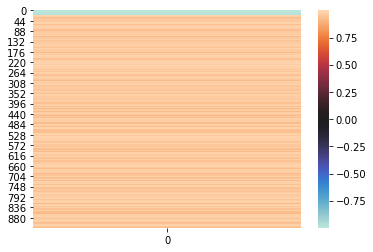

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 236
Hypothetical scores:


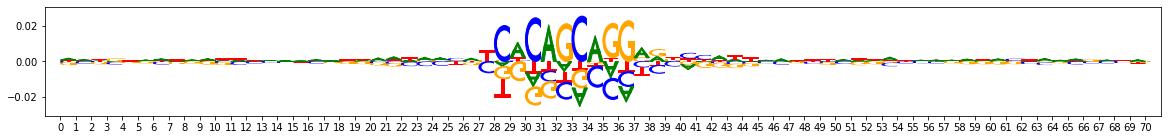

Actual importance scores:


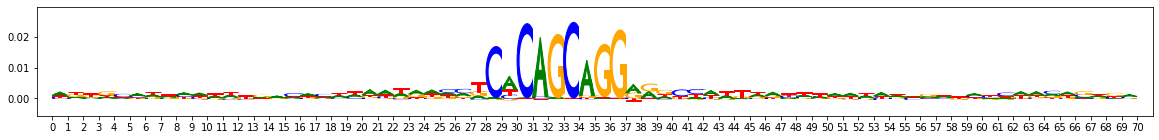

onehot, fwd and rev:


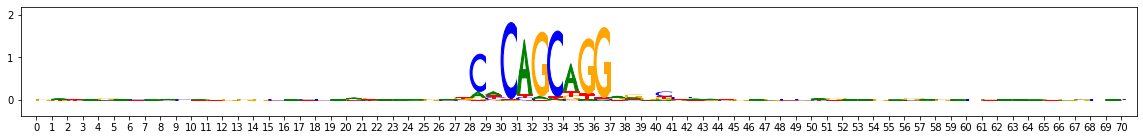

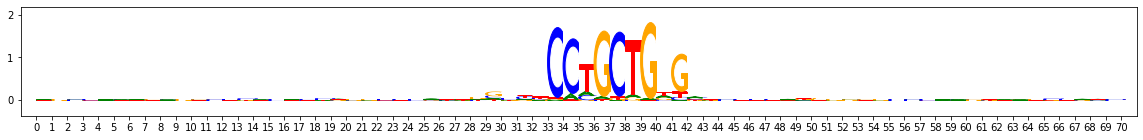

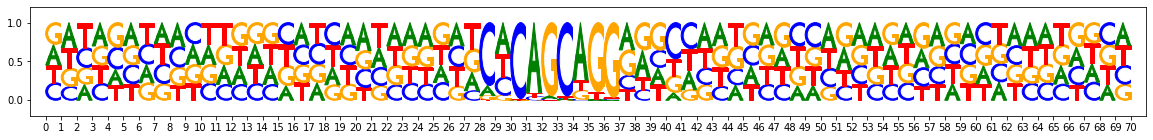

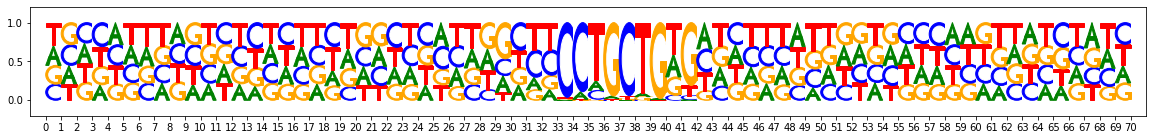

metacluster_0 pattern_1
total seqlets: 187
Hypothetical scores:


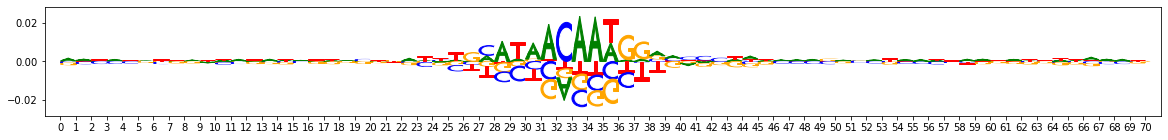

Actual importance scores:


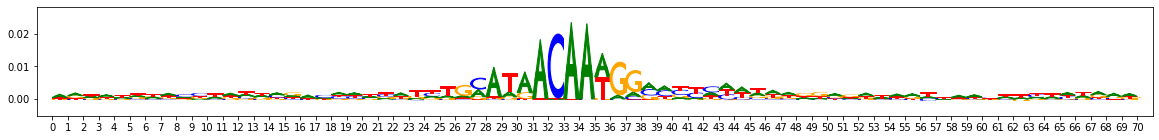

onehot, fwd and rev:


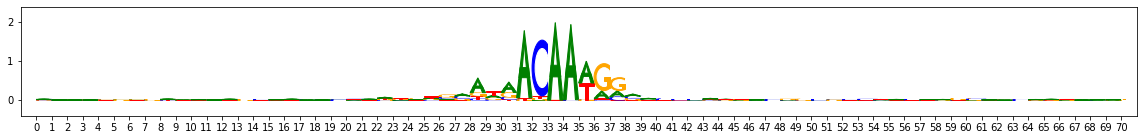

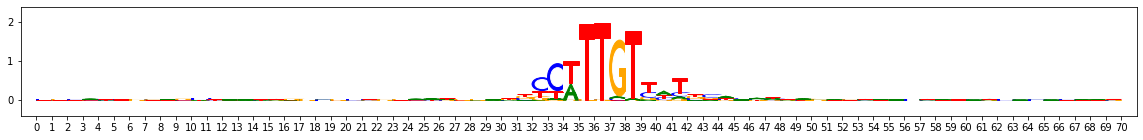

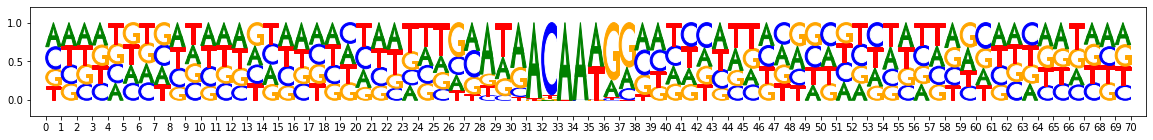

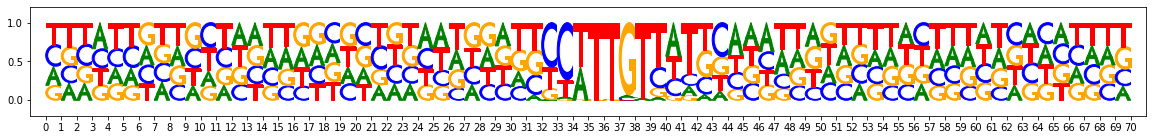

metacluster_0 pattern_2
total seqlets: 58
Hypothetical scores:


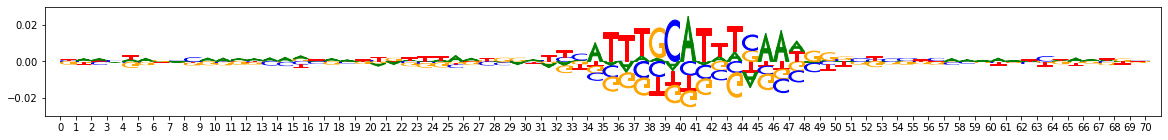

Actual importance scores:


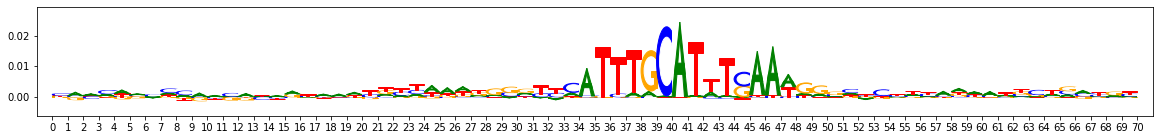

onehot, fwd and rev:


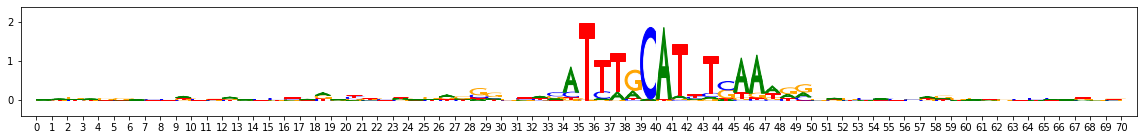

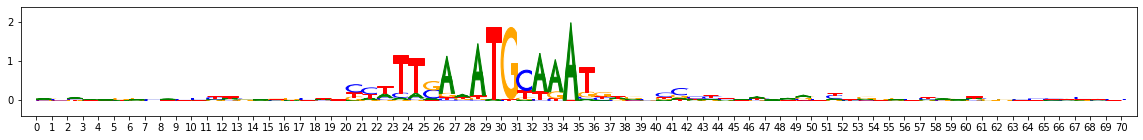

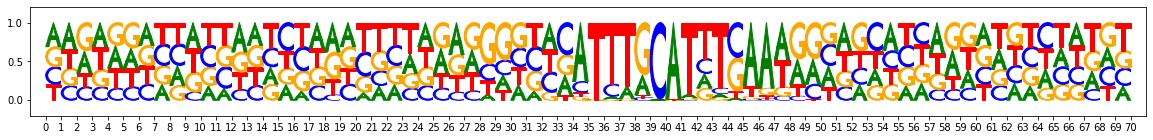

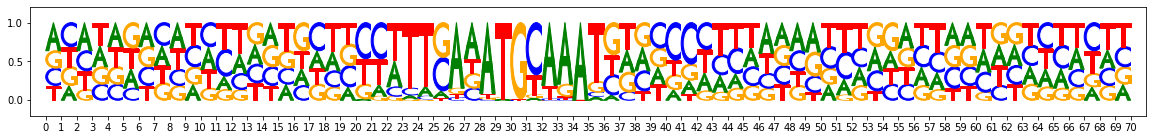

metacluster_0 pattern_3
total seqlets: 52
Hypothetical scores:


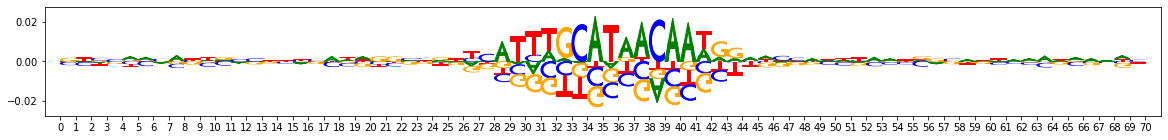

Actual importance scores:


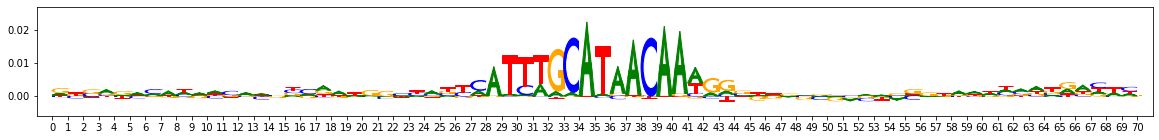

onehot, fwd and rev:


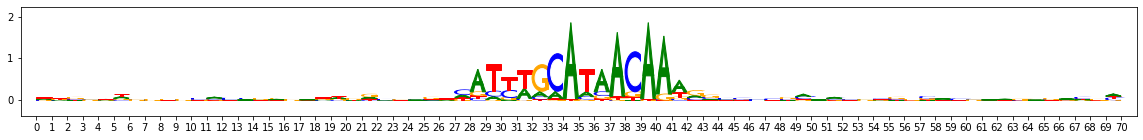

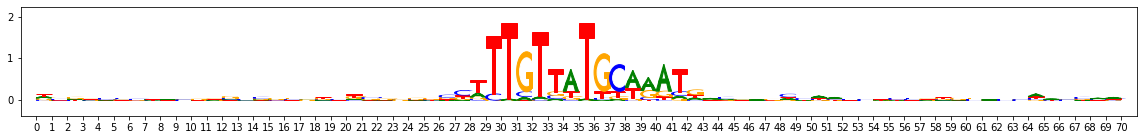

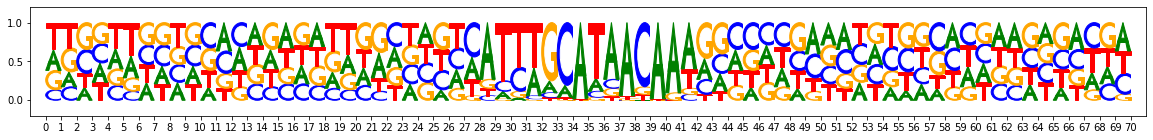

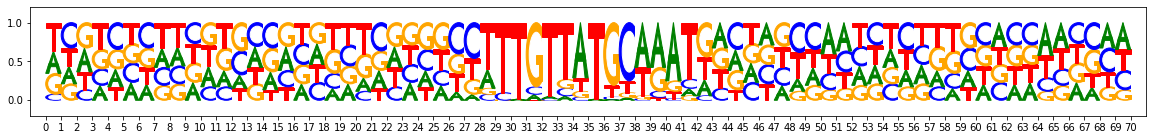

metacluster_0 pattern_4
total seqlets: 52
Hypothetical scores:


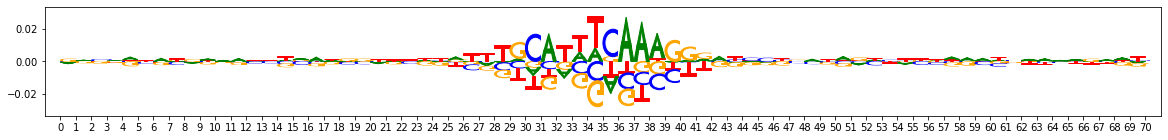

Actual importance scores:


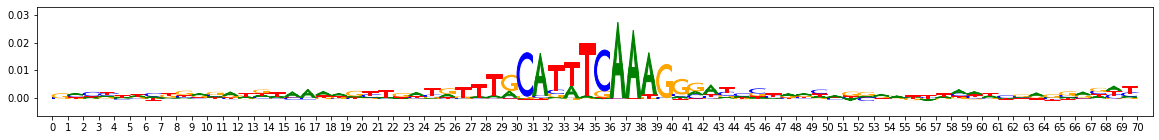

onehot, fwd and rev:


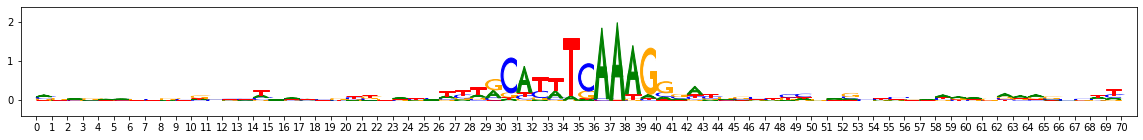

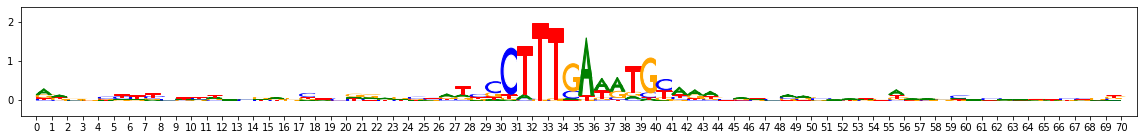

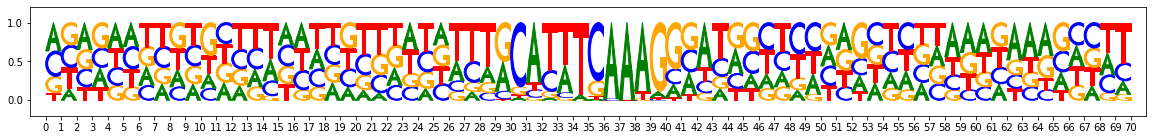

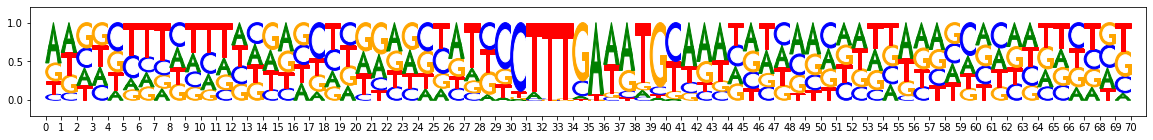

metacluster_0 pattern_5
total seqlets: 41
Hypothetical scores:


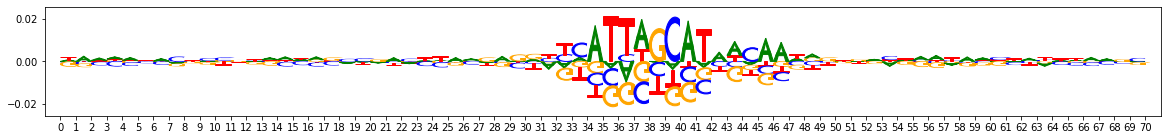

Actual importance scores:


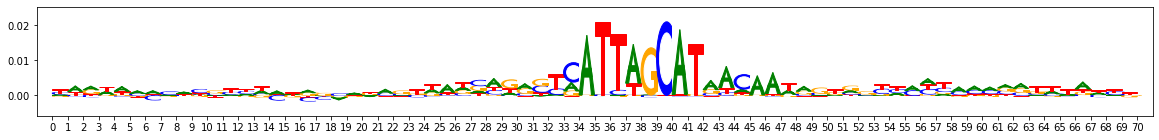

onehot, fwd and rev:


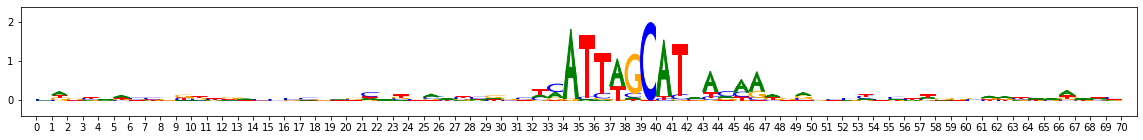

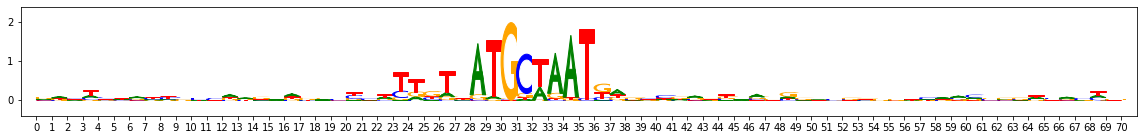

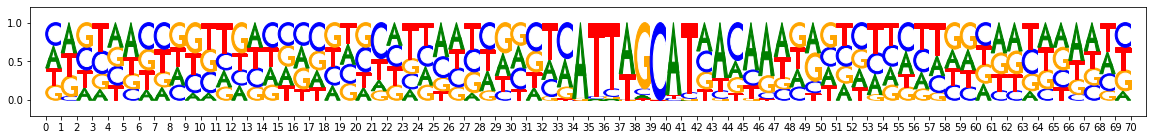

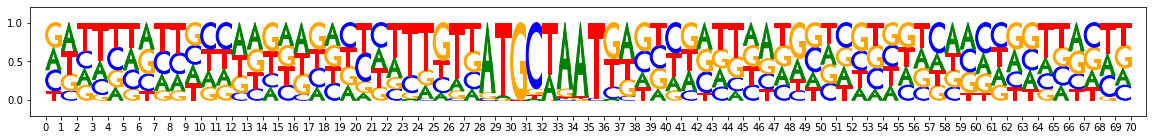

metacluster_0 pattern_6
total seqlets: 41
Hypothetical scores:


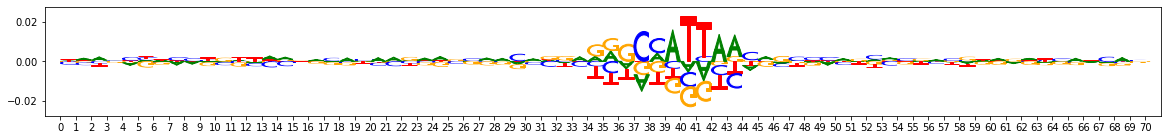

Actual importance scores:


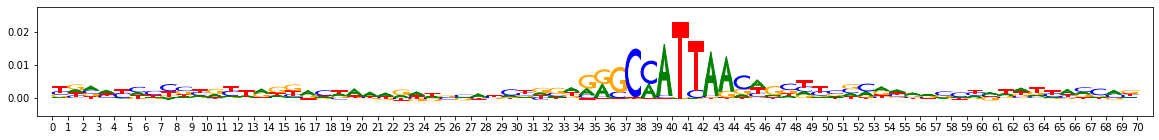

onehot, fwd and rev:


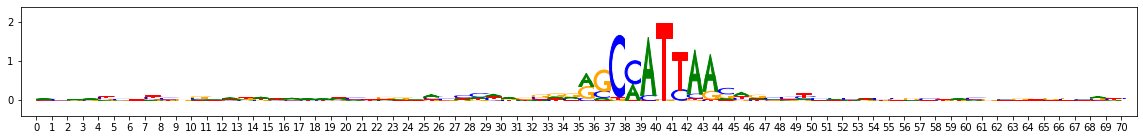

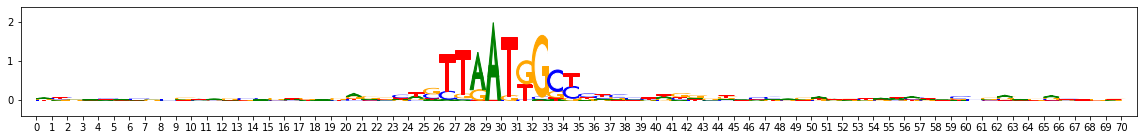

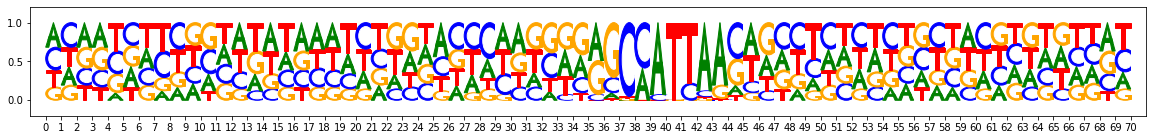

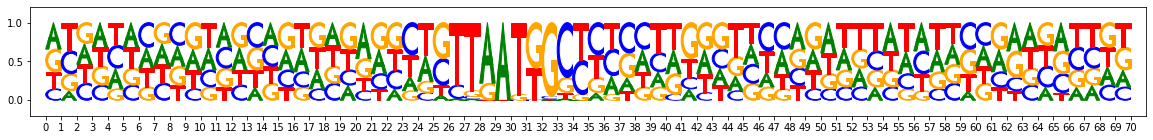

In [7]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()

### (extra) Visualize the result of using MEME's motifs to initialize the seqlets
This visualizes the intermediate stage where the MEME-derived motifs are used to create an initial set of seqlet clusters. Can be used to get insight into how the MEME-based initialization influenced the TF-MoDISco results

Inspecting meme-based initialization for seqlets in round 1
round 1 MEME-DISco motif number 0
num seqlets mapped to this motif: 250


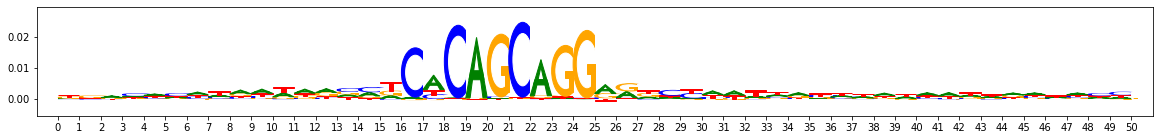

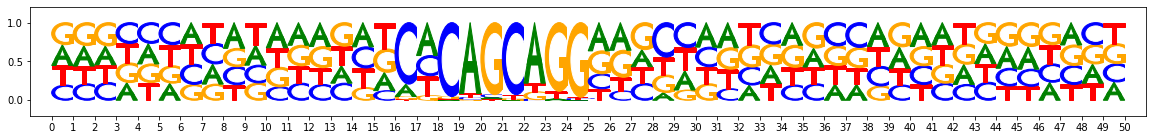

round 1 MEME-DISco motif number 1
num seqlets mapped to this motif: 214


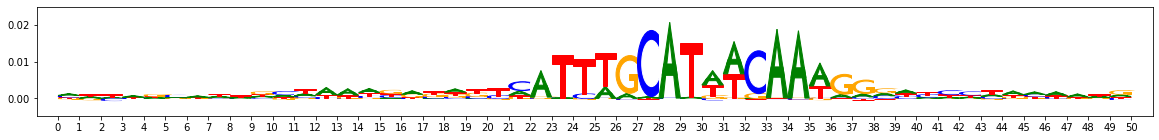

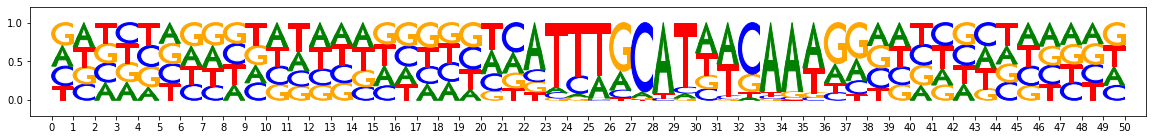

round 1 MEME-DISco motif number 2
num seqlets mapped to this motif: 157


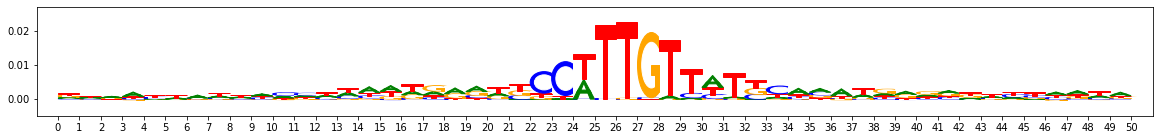

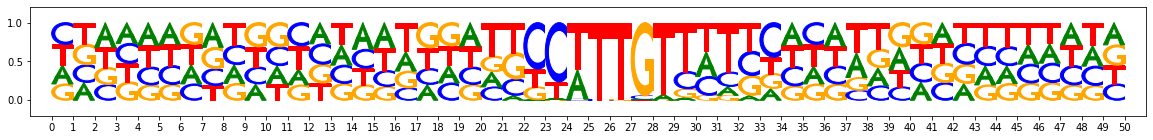

round 1 MEME-DISco motif number 3
num seqlets mapped to this motif: 63


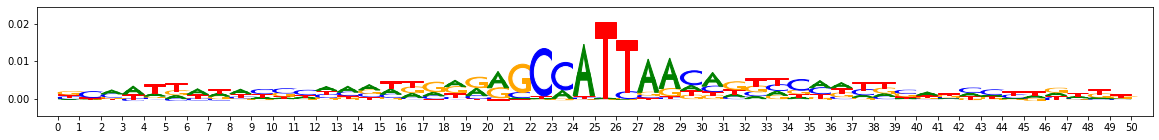

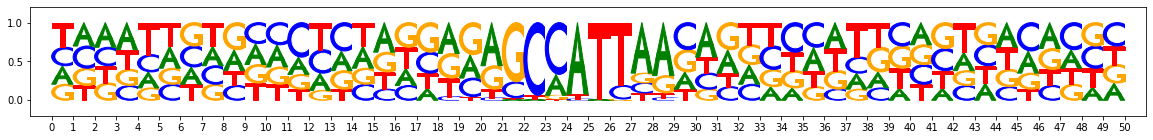

round 1 MEME-DISco motif number 4
num seqlets mapped to this motif: 36


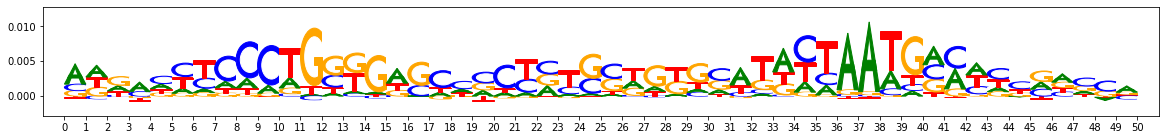

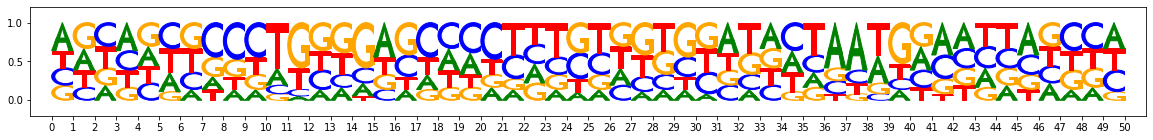

round 1 MEME-DISco motif number 5
num seqlets mapped to this motif: 14


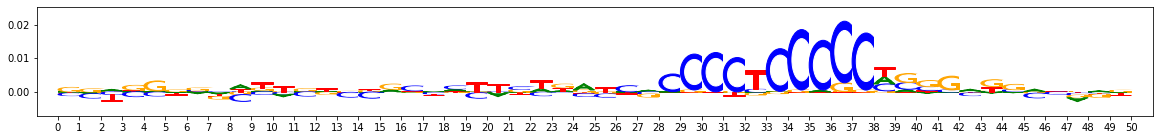

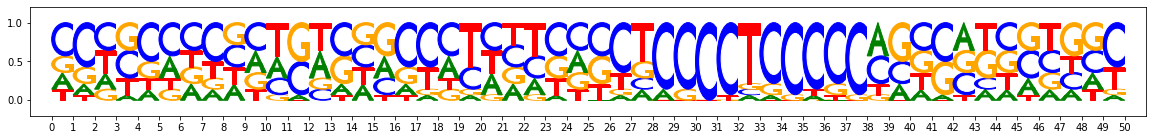

In [10]:
from modisco.visualization import viz_sequence
for round_idx in [1]:
    print("Inspecting meme-based initialization for seqlets in round",round_idx)
    meme_discovered_motifs = (tfmodisco_results
        .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
        .each_round_initcluster_motifs[round_idx])
    for idx,motif in enumerate(meme_discovered_motifs):
        print("round",round_idx,"MEME-DISco motif number",idx)
        print("num seqlets mapped to this motif:",len(motif.seqlets))
        viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(motif["sequence"].fwd)